<a href="https://colab.research.google.com/github/juhee2987/diaster-tweets/blob/main/diaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##구글 colab과 kaggle 연동

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle
#!pip install kaggle
from google.colab import files
files.upload()

     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=53d7c234555de695c2daaccc5aa4640d790a642ad8ea82e00fb8d8cdfbae98dc
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juhee2021","key":"c50e4fc72cf1bff4649eb3909f894ab6"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         92           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        100           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        915           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        162           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1861           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13974           False  
house-pr

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 36.1MB/s]


In [5]:
!ls

kaggle.json  nlp-getting-started.zip  sample_data


In [6]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


##Install and Import necessary modules

In [7]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 6.6 MB/s 
     |████████████████████████████████| 895 kB 34.5 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 
     |████████████████████████████████| 61 kB 453 kB/s 
     |████████████████████████████████| 3.3 MB 18.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
import seaborn as sns
from collections import defaultdict
import time
import pandas as pd
import matplotlib.pyplot as plt


from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers.models.auto import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup

In [9]:
# Select CPU/GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


##Dataloader

In [38]:
#Load the BERT tokenizer.


from transformers import AutoTokenizer
model_type = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_type)


'''
Dataloader 
For Training: Returns (Tweet, Input_id, Attention_mask, label)
For Testing: Returns (Tweet, Input_id, Attention_mask)
'''
class mydataset():    

    def __init__(self, classification_df, name = 'train'):

        super(mydataset).__init__()
        self.name = name
        self.tweet = []
        self.Y = []
                    
        for index,rows in classification_df.iterrows():

            tweet = rows['keyword'] + rows['location'] + rows['text']
            self.tweet.append(''.join(tweet)) 
            
            if name == 'train' or self.name == 'valid':
                label = rows['target']
                self.Y.append(label)

        #Tokenize all of the captions and map the tokens to thier word IDs, and get respective attention masks.

        self.input_ids, self.attention_masks = tokenize(self.tweet)


    def __getitem__(self,index): 

        #For Captions, Input ids and Attention mask

        tweet = self.tweet[index]
        input_id = self.input_ids[index]
        attention_masks = self.attention_masks[index]

        #For Labels during training 

        if self.name == 'train' or self.name == 'valid' :
            label = float(self.Y[index])
            
            return tweet, input_id, attention_masks, torch.as_tensor(label).long()
        
        else:
            return tweet, input_id, attention_masks
        

    def __len__(self):
        return len(self.tweet)

#tokenize all of the sentences and map the tokens to their word IDs.

def tokenize(sequences):
    
    input_ids = []
    attention_masks = []

    for seq in sequences:
        
        encoded_dict = tokenizer.encode_plus(
                            seq,                      
                            add_special_tokens = True, 
                            max_length = 32,           
                            truncation=True,
                            pad_to_max_length = True,
                            return_attention_mask = True,  
                            return_tensors = 'pt',    
                       )

       
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

In [40]:
#Shuffle and split 10 percent data for Validation set

train_csv = pd.read_csv('/content/train.csv', keep_default_na = False)
train_csv = train_csv.sample(frac=1).reset_index(drop=True)
ninetyfive_percent  = round(0.90*(len(train_csv)))
train_data = train_csv.iloc[:ninetyfive_percent]
valid_data = train_csv.iloc[ninetyfive_percent:]

print('Number of Training samples: ', len(train_data))
print('Number of Validation samples: ',len(valid_data))

Number of Training samples:  6852
Number of Validation samples:  761


In [41]:
#Train Dataloader

train_dataset = mydataset(train_data, name = 'train')
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=32,pin_memory=True)

#Validation_Dataloader

validation_dataset = mydataset(valid_data, name = 'valid')
validation_dataloader = data.DataLoader(validation_dataset, shuffle= True, batch_size = 32, num_workers=32,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [42]:
#Test Dataloader

test_csv = pd.read_csv('/content/test.csv', keep_default_na = False)
test_dataset = mydataset(test_csv , name = 'test')          
test_dataloader = data.DataLoader(test_dataset, shuffle= False, batch_size = 1, num_workers=16,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##Top keywords

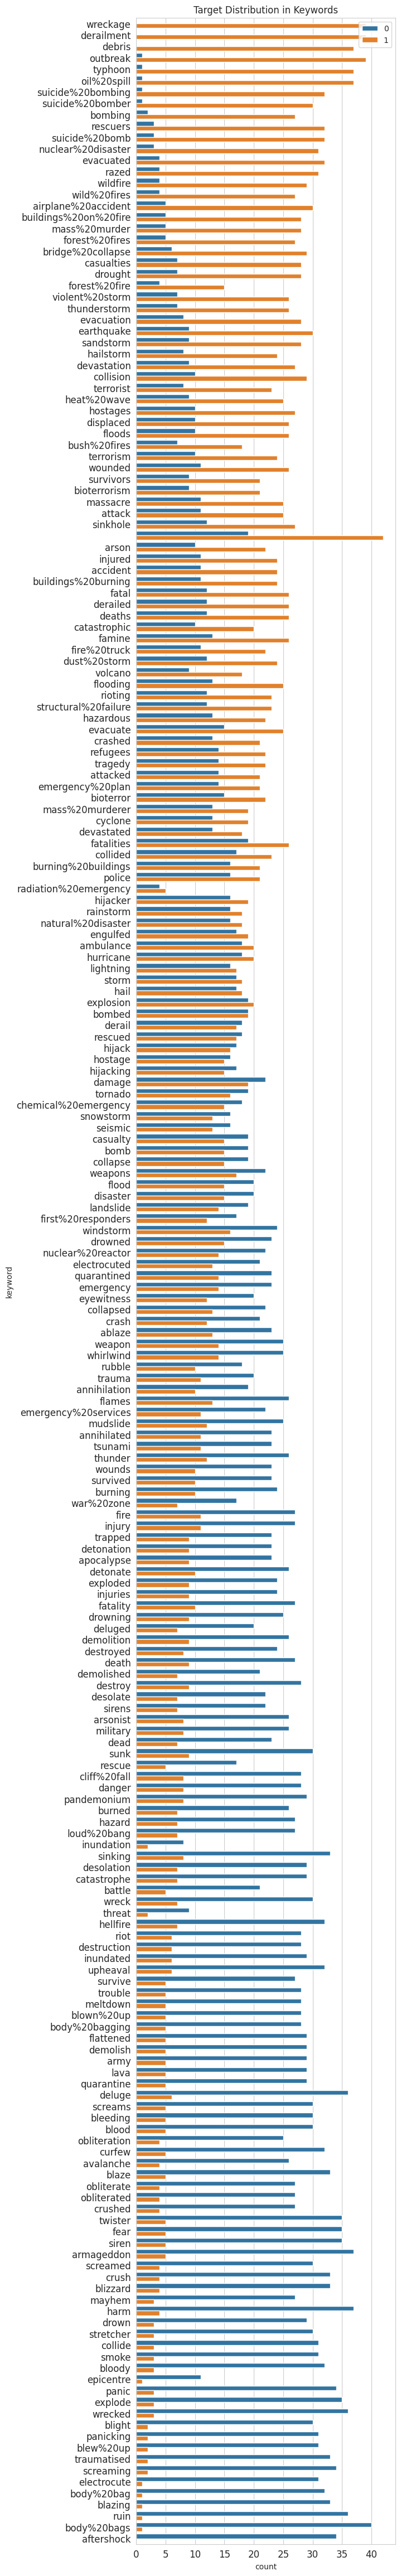

In [52]:
train_csv['target_mean'] = train_csv.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(6, 60), dpi=100)

sns.countplot(y=train_csv.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_csv.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_csv.drop(columns=['target_mean'], inplace=True)

###Suggest a Disaster Tweet

In [43]:
ag = train_csv.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag.sort_values('Disaster Probability', ascending=False).head(20)

,Count,Disaster Probability
keyword,,
wreckage,39,1.000000
debris,37,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


###Suggest not a Disaster Tweet

In [44]:
ag1 = train_csv.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag1.sort_values('Disaster Probability', ascending=True).head(20)

,Count,Disaster Probability
keyword,,
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
body%20bag,33,0.030303
electrocute,32,0.031250
screaming,36,0.055556
traumatised,35,0.057143
panicking,33,0.060606


##Model Definition

In [45]:
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
'''
import gc
gc.collect()
'''
torch.cuda.empty_cache()


model_type = 'bert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_type)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

##Trainer

In [46]:
def train(model, data_loader, valid_loader, criterion, optimizer, lr_scheduler, modelpath, device, epochs):
    
    model.train()

    train_loss= []
    valid_loss = []
    valid_acc = []


    for epoch in range(epochs):
        avg_loss = 0.0
                
        
        for batch_num, (tweet, input_id, attention_masks, target) in enumerate(data_loader):
            
            input_ids, attention_masks, target = input_id.to(device), attention_masks.to(device), target.to(device)
                
            #Compute output and loss from BERT

            loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=attention_masks, 
                             labels=target,
                             return_dict=False
                                )


            #Take Step

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            #Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            
            avg_loss += loss.item()

            #linear_schedule_with_warmup take step after each batch

            lr_scheduler.step()
                                
            
        training_loss = avg_loss/len(data_loader)
       
        print('Epoch: ', epoch+1)            
        print('training loss = ', training_loss)
        train_loss.append(training_loss)

        
        #Check performance on validation set after an Epoch
        
        validation_loss, top1_acc= test_classify(model, valid_loader, criterion, device)
        valid_loss.append(validation_loss)
        valid_acc.append(top1_acc)

         
        
        #save model checkpoint after every epoch
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            }, modelpath)
        
    return train_loss, valid_loss, valid_acc






'''
Function to perform inference on validation set
Returns: validation loss, top1 accuracy
'''

def test_classify(model, valid_loader, criterion, device):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    total = 0

    for batch_num, (tweet, input_id, attention_masks, target) in enumerate(valid_loader):
               
        input_ids, attention_masks, target = input_id.to(device), attention_masks.to(device), target.to(device)
            

        #Compute output and loss from BERT

        loss, logits = model(input_ids, 
                         token_type_ids=None, 
                         attention_mask=attention_masks, 
                         labels=target,
                         return_dict=False)

        test_loss.extend([loss.item()]*input_id.size()[0])
        
        predictions = F.softmax(logits, dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, target)).item()
        total += len(target)

    print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}'.format(np.mean(test_loss), top1_accuracy/total))
        
    return np.mean(test_loss), top1_accuracy/total

##Hyperparameters

In [47]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()

'''
Optimizer
'''
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

'''
Number of training epochs. The BERT authors recommend between 2 and 4. Increasing the number of epochs with BERT will increase overfitting the training set, as it can be seen from the loss plot later.
'''
num_Epochs = 4

'''
Create the learning rate scheduler.
Total number of training steps is [number of batches] x [number of epochs].
'''
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps
                                                = 0,  num_training_steps = total_steps)

##Time to start training

In [48]:
modelname = 'BERT'
modelpath = 'saved_checkpoint_'+modelname

train_loss, valid_loss, valid_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, device, epochs = num_Epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:  1
training loss =  0.46779958993889564
Validation Loss: 0.4097	Top 1 Validation Accuracy: 0.8279
Epoch:  2
training loss =  0.33624159430348594
Validation Loss: 0.4048	Top 1 Validation Accuracy: 0.8226
Epoch:  3
training loss =  0.21929770245455033
Validation Loss: 0.4516	Top 1 Validation Accuracy: 0.8187
Epoch:  4
training loss =  0.129946488280629
Validation Loss: 0.5321	Top 1 Validation Accuracy: 0.8160


##Visualize Loss and Accuracy plots

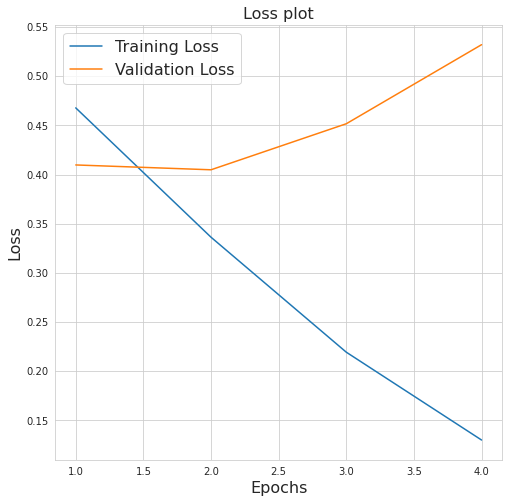

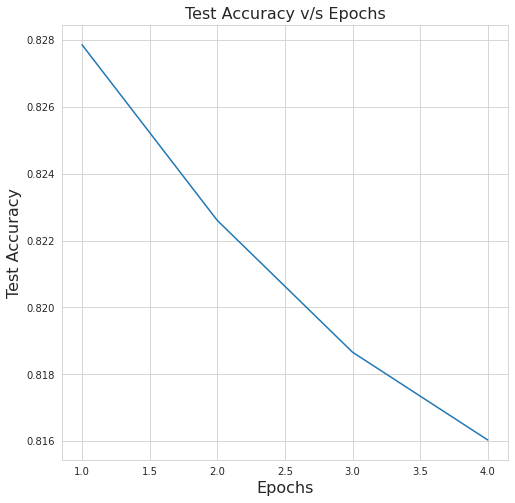

In [49]:
def plot_loss(epochs, train_loss, test_loss, title):
    plt.figure(figsize=(8,8))
    x = np.arange(1,epochs+1)
    plt.plot(x, train_loss, label = 'Training Loss')
    plt.plot(x, test_loss, label = 'Validation Loss')
    plt.xlabel('Epochs', fontsize =16)
    plt.ylabel('Loss', fontsize =16)
    plt.title(title,fontsize =16)
    plt.legend(fontsize=16)
    
    
def plot_acc(epochs,test_acc):
    plt.figure(figsize=(8,8))
    x = np.arange(1,epochs+1)
    plt.plot(x, test_acc)
    plt.xlabel('Epochs', fontsize =16)
    plt.ylabel('Test Accuracy', fontsize =16)
    plt.title('Test Accuracy v/s Epochs',fontsize =16)
    
    
sns.set_style("whitegrid")
plot_loss(num_Epochs, train_loss, valid_loss, title='Loss plot')
plot_acc(num_Epochs, valid_acc)

##Predict and generate submission.csv

In [50]:
def predict(model, test_loader, device):
    model.eval()
    target = []
    for batch_num, (captions, input_id, attention_masks) in enumerate(test_loader):
     
        
        input_ids, attention_masks = input_id.to(device), attention_masks.to(device)
            
        #Compute prediction outputs from BERT

        output_dictionary = model(input_ids, 
                         token_type_ids=None, 
                         attention_mask=attention_masks, 
                         return_dict=True)
        
        predictions = F.softmax(output_dictionary['logits'], dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.item()        
        target.append(top1_pred_labels)
        
        
    make_csv(target)
        

def make_csv(target):
    test = pd.read_csv('/content/test.csv')
    my_submission = pd.DataFrame({'id': test.id, 'target': target})
    my_submission.to_csv('submission.csv', index=False)

In [51]:
predict(model, test_dataloader, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
